<a href="https://colab.research.google.com/github/NoelleI/Udacity-Deployment/blob/master/Heartbeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install mtcnn

     |████████████████████████████████| 2.3MB 4.2MB/s 


In [34]:


'''Step 1 Detect Skin 
this code was adapted from https://www.pyimagesearch.com/2014/08/18/skin-detection-step-step-example-using-python-opencv/
and
https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/'''

# import the necessary packages
import imutils
import numpy as np
import argparse
import cv2
from matplotlib import pyplot
from mtcnn import MTCNN
from google.colab.patches import cv2_imshow
# construct the argument parse and parse the arguments

# define the upper and lower boundaries of the HSV pixel
# intensities to be considered 'skin'
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")
# if a video path was not supplied, grab the reference
# to the gray


camera = cv2.VideoCapture("skin_detect.MOV")
n_frames = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
#classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


''''change this'''


ra = []
ga = []
ba = []

# keep looping over the frames in the video
for i in range(n_frames):
    
    print(i)
	# grab the current frame
    (grabbed, frame) = camera.read()
	# if we are viewing a video and we did not grab a
	# frame, then we have reached the end of the video
	# resize the frame, convert it to the HSV color space,
	# and determine the HSV pixel intensities that fall into
	# the speicifed upper and lower boundaries
    if grabbed:
        frame = imutils.resize(frame, width = 400)
    
        converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        skinMask = cv2.inRange(converted, lower, upper)
	# apply a series of erosions and dilations to the mask
	# using an elliptical kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        skinMask = cv2.erode(skinMask, kernel, iterations = 2)
        skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
	# blur the mask to help remove noise, then apply the
	# mask
        skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
        skin = cv2.bitwise_and(frame, frame, mask = skinMask)
        #find the average red, green and blue in the skin
        N = 0
        r=0
        g=0
        b=0
        skinr = skin[:,:,0].reshape(-1)
        sking = skin[:,:,1].reshape(-1)
        skinb = skin[:,:,2].reshape(-1)

        #print(skinMask.shape)
        for i, pixel in enumerate(skinMask.reshape(-1)):
          if  not pixel==0:
            r += skinr[i]
            g += sking[i]
            b += skinb[i]
            N+=1
        ra += [r/N] 
        ga += [g/N]
        ba += [b/N]




	# show the skin in the image along with the mask
        
        #detector = MTCNN()
        # detect faces in the image
        #faces = detector.detect_faces(frame)
        #print("len faces =", len(faces))
        
    
        #bboxes = classifier.detectMultiScale(frame, 1.005, 3)
        #print('len bboxes:', len(bboxes))
# print bounding box for each detected face
        #for box in bboxes:
	# extract
            #[x, y, width, height] = box 
           # x2 = x + width
            #y2 = y + height
           	# draw a rectangle over the pixels
            #cv2.rectangle(frame, (x, y), (x2, y2), (0,0,255), 1)
        #cv2_imshow(np.vstack([frame, skin]))
# cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [35]:
ra = np.array(ra)

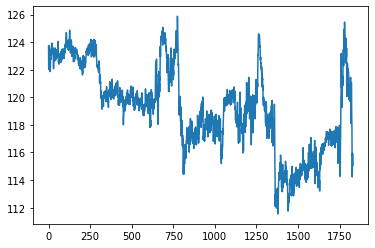

In [51]:
import matplotlib.pyplot as plt

plt.plot(ra)

In [39]:
ga = np.array(ga)
ba = np.array(ba)

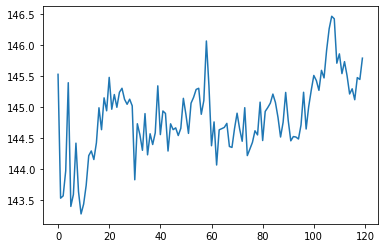

In [45]:
plt.plot(ga[:120])

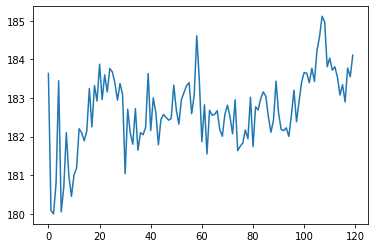

In [47]:
plt.plot(ba[:120])

In [52]:
X = np.array(list(zip(ra,ga,ba)))

In [53]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=3)

In [54]:
X_transformed = transformer.fit_transform(X)

In [55]:
X_indep = X_transformed.transpose()

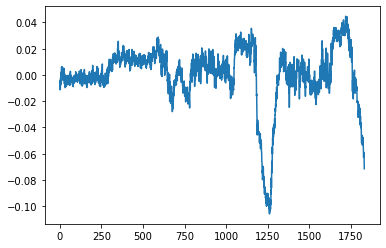

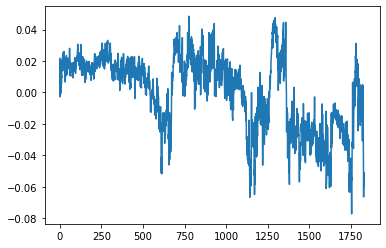

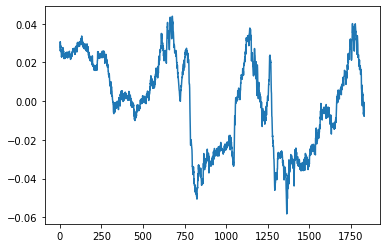

In [56]:
plt.plot(X_indep[0])
plt.show()
plt.plot(X_indep[1])
plt.show()
plt.plot(X_indep[2])
plt.show()

In [101]:
from scipy import signal
x1 = X_indep[1] - X_indep[1].mean()
x1_corr = signal.correlate(x1, x1, mode='same')

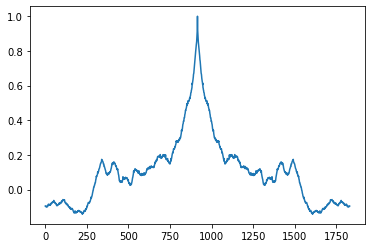

In [87]:
plt.plot(x1_corr)

In [102]:
ff = np.fft.hfft(x1_corr[:int(len(x1_corr)/2)])

In [89]:
fs_n = 30/len(x1_corr/2)

In [90]:
4/fs_n

244.13333333333333

In [91]:
0.75/fs_n

45.775

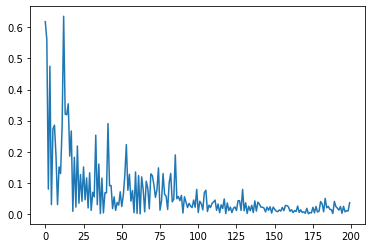

In [109]:
plt.plot((abs(ff[45:245])))

In [93]:
(np.argmax(abs(ff[45:245])) + 45)*60*fs_n

59.96723102129984

In [94]:
from scipy.stats import kurtosis as kurt

In [103]:
kurt(ff[45:245])

6.7330337740098685

In [96]:
x2 = X_indep[2] - X_indep[2].mean()
x2_corr = signal.correlate(x2, x2, mode='same')

In [108]:
ff = np.fft.hfft(x2_corr[:int(len(x2_corr)/2)])

In [100]:
kurt(ff[45:245])

11.06132946434613

In [104]:
x0 = X_indep[0] - X_indep[0].mean()
x0_corr = signal.correlate(x0, x0, mode='same')

In [105]:
ff = np.fft.hfft(x0_corr[:int(len(x0_corr)/2)])

In [106]:
kurt(ff[45:245])

6.561904544497091